In [1]:
import numpy as np
import torch
import torch_geometric
import networkx as nx
import math
import matplotlib.pyplot as plt
from random import randint, shuffle
from collections import defaultdict

from torch_geometric.utils import from_networkx, to_networkx
from torch_geometric.loader import DataLoader
from torch_scatter import scatter_mean, scatter_std, scatter_min, scatter_max

from GOOD.utils.synthetic_data import synthetic_structsim
from GOOD.utils.args import args_parser, CommonArgs
from GOOD import config_summoner
from GOOD.kernel.main import initialize_model_dataset
from GOOD.kernel.pipeline_manager import load_pipeline
from GOOD.ood_algorithms.ood_manager import load_ood_alg
from GOOD.utils.initial import reset_random_seed
import GOOD.kernel.pipelines.xai_metric_utils as xai_utils
from GOOD.kernel.pipelines.basic_pipeline import CustomDataset

from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
from sklearn.feature_selection import r_regression
from sklearn.model_selection import train_test_split

%load_ext autoreload
%autoreload 2


In [2]:
def normalize_belonging(belonging):
        #TODO: make more efficient
        ret = []
        i = -1
        for j , elem in enumerate(belonging):
            if len(ret) > 0 and elem == belonging[j-1]:
                ret.append(i)
            else:
                i += 1
                ret.append(i)
        return torch.tensor(ret, dtype=int)

def plot_base(p):
    plt.figure(figsize=(2,2))
    nx.draw(p)
    plt.show()

house, _ = synthetic_structsim.house(start=0)
crane, _ = synthetic_structsim.crane(start=0)
dircycle, _ = synthetic_structsim.dircycle(start=0)
path, _ = synthetic_structsim.path(start=0, width=11)
# plot_base(crane)

## Load models and dataset

In [3]:
DATASET = "GOODMotif/size"
SEED = 3
DEVICE = "cuda:1"
SPLIT = "id_val"
MODEL = "LECI"

In [4]:
args = CommonArgs(argv=None)
config_path = f"./final_configs/{DATASET}/covariate/LECI.yaml"
args.process_args_manual(config_path)
args.random_seed = SEED
args.exp_round = SEED
config = config_summoner(args)
config["mitigation_backbone"] = None
config["mitigation_sampling"] = "feat"
config["task"] = "test"
config["device"] = DEVICE
leci, loader = initialize_model_dataset(config)
leci_ood_algorithm = load_ood_alg(config.ood.ood_alg, config)
leci_pipeline = load_pipeline(config.pipeline, config.task, leci, loader, leci_ood_algorithm, config)
leci_pipeline.load_task(load_param=True, load_split="id")
leci_pipeline.model.eval()


args = CommonArgs(argv=None)
args.random_seed = SEED
args.exp_round = SEED
config_path = f"./final_configs/{DATASET}/covariate/CIGA.yaml"
args.process_args_manual(config_path)
config = config_summoner(args)
config["mitigation_backbone"] = None
config["mitigation_sampling"] = "feat"
config["task"] = "test"
config["device"] = DEVICE
ciga, _ = initialize_model_dataset(config)
ciga_ood_algorithm = load_ood_alg(config.ood.ood_alg, config)
ciga_pipeline = load_pipeline(config.pipeline, config.task, ciga, loader, ciga_ood_algorithm, config)
ciga_pipeline.load_task(load_param=True, load_split="id") 
ciga_pipeline.model.eval()


args = CommonArgs(argv=None)
args.random_seed = SEED
args.exp_round = SEED
config_path = f"./final_configs/{DATASET}/covariate/GSAT.yaml"
args.process_args_manual(config_path)
config = config_summoner(args)
config["mitigation_backbone"] = None
config["mitigation_sampling"] = "feat"
config["task"] = "test"
config["device"] = DEVICE
gsat, _ = initialize_model_dataset(config)
gsat_ood_algorithm = load_ood_alg(config.ood.ood_alg, config)
gsat_pipeline = load_pipeline(config.pipeline, config.task, gsat, loader, gsat_ood_algorithm, config)
gsat_pipeline.load_task(load_param=True, load_split="id")
gsat_pipeline.model.eval()

#IN#
-----------------------------------
    Task: test
Thu Feb 29 19:11:26 2024
#IN#Load Dataset GOODMotif
#D#Dataset: {'train': GOODMotif(18000), 'id_val': GOODMotif(3000), 'id_test': GOODMotif(3000), 'val': GOODMotif(3000), 'test': GOODMotif(3000), 'task': 'Multi-label classification', 'metric': 'Accuracy'}
#D# Data(edge_index=[2, 58], x=[17, 1], node_gt=[17], edge_gt=[58], y=[1], env_id=[1], num_nodes=17)
Data(edge_index=[2, 80], x=[22, 1], node_gt=[22], edge_gt=[80], y=[1], env_id=[1], num_nodes=22)
#IN#Loading model...
#D#Init GINFeatExtractor
#D#Using the fixed _explain_ functionality
#D#Using no mitigation (None)
#D#Using the fixed _explain_ functionality
#D#Using no mitigation (None)
#D#Using the fixed _explain_ functionality
#D#Using no mitigation (None)
Using feature sampling := feat
self.EF = 0
#D#Init GINFeatExtractor
#D#Using the fixed _explain_ functionality
#D#Using no mitigation (None)
#D#Using the fixed _explain_ functionality
#D#Using no mitigation (None)
#D#Using th

GSATGIN(
  (gnn): GINFeatExtractor(
    (encoder): GINEncoder(
      (relus): ModuleList(
        (0-2): 3 x ReLU()
      )
      (batch_norms): ModuleList(
        (0-2): 3 x BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (dropouts): ModuleList(
        (0-2): 3 x Dropout(p=0.5, inplace=False)
      )
      (readout): GlobalMeanPool()
      (convs): ModuleList(
        (0-2): 3 x GINConvAttn()
      )
    )
  )
  (extractor): ExtractorMLP(
    (feature_extractor): MLP(
      (0): Linear(in_features=600, out_features=1200, bias=True)
      (1): InstanceNorm(1200)
      (2): ReLU()
      (3): Dropout(p=0.5, inplace=False)
      (4): Linear(in_features=1200, out_features=300, bias=True)
      (5): InstanceNorm(300)
      (6): ReLU()
      (7): Dropout(p=0.5, inplace=False)
      (8): Linear(in_features=300, out_features=1, bias=True)
    )
  )
  (classifier): Classifier(
    (classifier): Sequential(
      (0): Linear(in_features=300, out_f

##### Check Model Accuracy

In [5]:
print("LECI")
leci_pipeline.evaluate("id_val", compute_suff=False);
leci_pipeline.evaluate("test", compute_suff=False);

print("GSAT")
gsat_pipeline.evaluate("id_val", compute_suff=False);
gsat_pipeline.evaluate("test", compute_suff=False);

print("CIGA")
ciga_pipeline.evaluate("id_val", compute_suff=False);
ciga_pipeline.evaluate("test", compute_suff=False);

LECI


Id_val ACCURACY: 0.9070Id_val Loss: 0.3512
Test ACCURACY: 0.5750Test Loss: 2.3806
GSAT
Id_val ACCURACY: 0.9347Id_val Loss: 0.3191
Test ACCURACY: 0.4643Test Loss: 4.1976
CIGA
Id_val ACCURACY: 0.9103Id_val Loss: 0.3674
Test ACCURACY: 0.4693Test Loss: 2.1615


In [6]:
if MODEL == "LECI":
    tested_pipeline = leci_pipeline
    tested_ood_algorithm = leci_ood_algorithm
    tested_model = leci
elif MODEL == "GSAT":
    tested_pipeline = gsat_pipeline
    tested_ood_algorithm = gsat_ood_algorithm
    tested_model = gsat
elif MODEL == "CIGA":
    tested_pipeline = ciga_pipeline
    tested_ood_algorithm = ciga_ood_algorithm
    tested_model = ciga

## How likely is to pick an edge in the explanation in NEC?

In [7]:
def sample_edges(G_ori, data, alpha, edge_index_to_remove=None, ratio=None, edge_remove=None, num_to_remove=None, remove_undirected=False):
    # keep each spu/inv edge with probability alpha
    G = G_ori.copy()

    if edge_remove is None:
        if remove_undirected:
            # removing directed edges may introduce a spurious dependence on |R| as for large |R| is more likely to pick different directed edges, and since I
            # remove both directions this result in more dropped edges.
            # so in this case force to pick always different edges
            edges = [(u.item(), v.item()) for u, v in edge_index_to_remove.T if u < v]
        else:
            edges = [(u.item(), v.item()) for u, v in edge_index_to_remove.T]
        shuffle(edges)
        num_to_remove = max(1, int(len(G.edges()) * ratio * (1-alpha))) if num_to_remove is None else num_to_remove
        # num_to_remove = min(num_to_remove, 1) # pick at least one element
        edge_remove = edges[:num_to_remove] #remove the 1-alpha% of the undirected edges

    G.remove_edges_from(edge_remove)
    G.remove_edges_from([(v,u) for v,u in G.edges() if not G.has_edge(u,v)])
    if len(G.edges()) == 0:
        G.add_edges_from([(edge_remove[0][0], edge_remove[0][1]), (edge_remove[0][1], edge_remove[0][0])])
    G.remove_nodes_from(list(nx.isolates(G)))

    # count how many GT edges where removed
    edge_gt = {(u.item(),v.item()): bool(data.edge_gt[i]) for i, (u,v) in enumerate(data.edge_index.T)} 
    edges_in_gt = sum([edge_gt[e] for e in edge_remove])
    # print(f"Removing {num_to_remove} edges")
    return G, edges_in_gt

In [8]:
##
# Extract edge scores
##

edge_scores, graphs, labels = [], [], []
for data in loader[SPLIT]:    
    data = data.to(config.device)
    edge_score = tested_model.get_subgraph(
        data=data,
        edge_weight=None,
        ood_algorithm=tested_ood_algorithm,
        do_relabel=False,
        return_attn=False,
        ratio=None
    )
    for j, g in enumerate(data.to_data_list()):
        g.ori_x = data.ori_x[data.batch == j]
        edge_scores.append(edge_score[data.batch[data.edge_index[0]] == j].detach().cpu())
        graphs.append(g.detach().cpu())
    labels.extend(data.y.detach().cpu().numpy().tolist())
labels = torch.tensor(labels)
graphs_nx = [to_networkx(g, node_attrs=["ori_x"], edge_attrs=["edge_attr"] if not g.edge_attr is None else None) for g in graphs]

if hasattr(graphs[0], "edge_gt"):
    num_gt_edges = torch.tensor([data.edge_gt.sum() for data in graphs])
    num_all_edges = torch.tensor([data.edge_index.shape[1] for data in graphs])
    print("\nGold ratio = ", torch.mean(num_gt_edges / num_all_edges), "+-", torch.std(num_gt_edges / num_all_edges))

causal_subgraphs_r, spu_subgraphs_r, expl_accs_r = {}, {}, {}
for ratio in [0.3, 0.4, 0.6, 0.7, 0.75, 0.8, 0.9, 1.]:
    reset_random_seed(config)
    causal_subgraphs_r[ratio], spu_subgraphs_r[ratio], expl_accs_r[ratio] = tested_pipeline.get_subragphs_ratio(graphs, ratio, edge_scores) 
    print(f"F1 for r = {ratio} = {np.mean([e[1] for e in expl_accs_r[ratio]]):.3f}")
    print(f"WIoU for r = {ratio} = {np.mean([e[0] for e in expl_accs_r[ratio]]):.3f}")


Gold ratio =  tensor(0.3588) +- tensor(0.1832)
F1 for r = 0.3 = 0.283
WIoU for r = 0.3 = 0.211
F1 for r = 0.4 = 0.394
WIoU for r = 0.4 = 0.300
F1 for r = 0.6 = 0.491
WIoU for r = 0.6 = 0.382
F1 for r = 0.7 = 0.516
WIoU for r = 0.7 = 0.410
F1 for r = 0.75 = 0.521
WIoU for r = 0.75 = 0.419
F1 for r = 0.8 = 0.523
WIoU for r = 0.8 = 0.432
F1 for r = 0.9 = 0.520
WIoU for r = 0.9 = 0.452
F1 for r = 1.0 = 0.503
WIoU for r = 1.0 = 0.455


In [132]:
metric = "nec++"

removed_edges_in_gt = defaultdict(list)
for ratio in [0.3, 0.6, 0.9]:
    reset_random_seed(config)    
    causal_subgraphs, spu_subgraphs, expl_accs = causal_subgraphs_r[ratio], spu_subgraphs_r[ratio], expl_accs_r[ratio]

    for i in range(len(graphs)):
        G = graphs_nx[i].copy()
        if len(G.edges()) == 0:
            continue

        if metric == "nec++":
            alpha = max(config.nec_alpha_1 - 0.1 * (j // 3), 0.1)
        else:
            alpha = config.nec_alpha_1
        
        G_sampled, edges_in_gt = sample_edges(G, graphs[i], "inv", alpha, causal_subgraphs[i], ratio=1)
        removed_edges_in_gt[ratio].append(edges_in_gt)
            

KeyboardInterrupt: 

Text(0.5, 1.0, 'Drop edges depending on |G|')

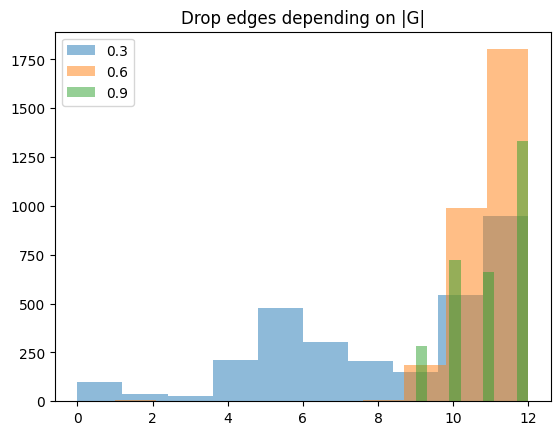

In [222]:
for ratio in [0.3, 0.6, 0.9]:
    plt.hist(removed_edges_in_gt[ratio], alpha=0.5, label=ratio);
plt.legend()
plt.title("Drop edges depending on |G|")

Text(0.5, 1.0, 'Drop edges depending on |R|')

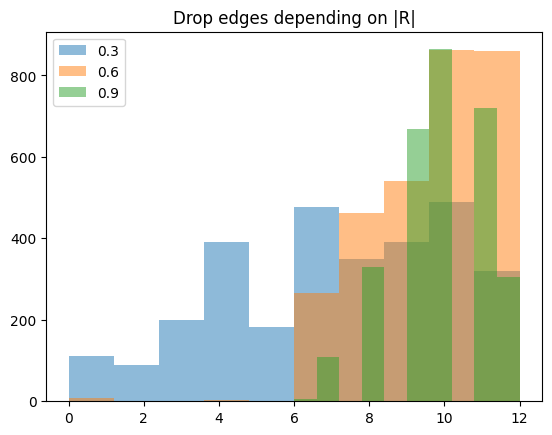

In [220]:
for ratio in [0.3, 0.6, 0.9]:
    plt.hist(removed_edges_in_gt[ratio], alpha=0.5, label=ratio);
plt.legend()
plt.title("Drop edges depending on |R|")

Text(0.5, 1.0, 'Always remove 1')

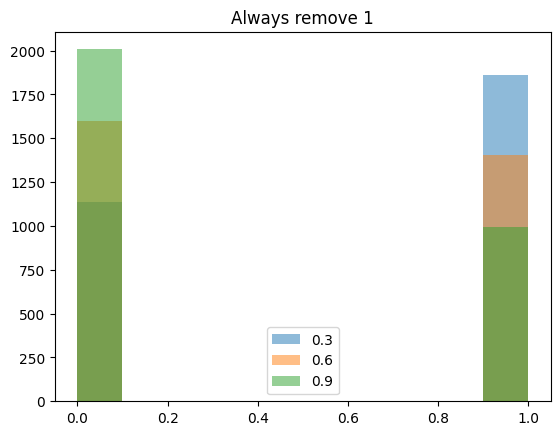

In [217]:
for ratio in [0.3, 0.6, 0.9]:
    plt.hist(removed_edges_in_gt[ratio], alpha=0.5, label=ratio);
plt.legend()
plt.title("Always remove 1")

## Inspect NEC for some examples

In [9]:
def get_title_predition(ori_pred, pred, idx, gt, edges_in_gt):
    def get_tensor_pred(pred, idx):
        return "[" + ", ".join([str(o.item())[:4] for o in pred[idx]]) + "]"
    return f"Orig. Pred: {get_tensor_pred(ori_pred, idx)}\nPert. Pred: {get_tensor_pred(pred, idx)}\nGT: {gt.item()} Sampled in R*: {edges_in_gt}"

def predict_sample(graphs, pipeline, ratio):
    eval_set = CustomDataset("", graphs, torch.arange(len(graphs)))
    loader = DataLoader(eval_set, batch_size=256, shuffle=False, num_workers=0)
    # preds, _ = pipeline.evaluate_graphs(loader, log=True)
    preds, belonging = pipeline.evaluate_graphs(loader, log=True, weight=ratio, is_ratio=True, eval_kl=True)
    return preds

def draw(config, G, name, subfolder="", pos=None, save=True, figsize=(6.4, 4.8), nodesize=300, with_labels=True, title=None, ax=None):
    edge_colors = {
        "inv": "green",
        "spu": "blue",
        "added": "red"
    }
    
    if pos is None:
        pos = nx.kamada_kawai_layout(G)

    edge_color = list(map(lambda x: edge_colors[x], nx.get_edge_attributes(G,'origin').values()))
    nx.draw(
        G,
        with_labels=with_labels,
        pos=pos,
        ax=ax,
        node_size=nodesize,
        edge_color=edge_color
    )
    if nx.get_edge_attributes(G, 'attn_weight') != {}:
        nx.draw_networkx_edge_labels(G, pos, edge_labels=nx.get_edge_attributes(G, 'attn_weight'), font_size=6, alpha=0.8)
    
    title = title if not title is None else f"Selected {sum([e == 'green' for e in edge_color])} relevant edges"
    if ax is None:
        plt.title(title, fontsize=8)
    else:
        ax.set_title(title, fontsize=8)

Motif Classes: ```[[["house"]], [["dircycle"]], [["crane"]]]```

Removing 2 edges
tensor([[1.5043e-07, 9.9994e-01, 5.6837e-05]])
GT: tensor([0])
Selected 22 relevant edges over 36


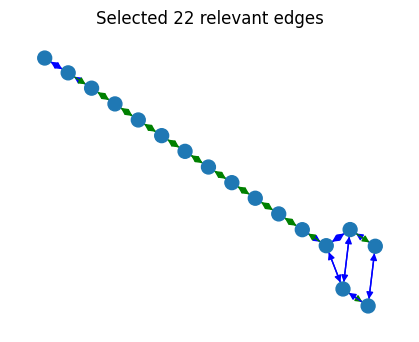

In [96]:
ratio = 0.6
idx = idxs[101]

G = graphs_nx[idx].copy()
xai_utils.mark_edges(G, causal_subgraphs_r[ratio][idx], spu_subgraphs_r[ratio][idx])
num_to_remove = max(1, int(len(G.edges()) * ratio * (1 - config.nec_alpha_1)))
print(f"Removing {num_to_remove} edges")
print(predict_sample([G], tested_pipeline, ratio=ratio).exp())
print(f"GT: {graphs[idx].y}")
pos = xai_utils.draw(config, G, name="", save=False, figsize=(4, 3), nodesize=100, with_labels=False);

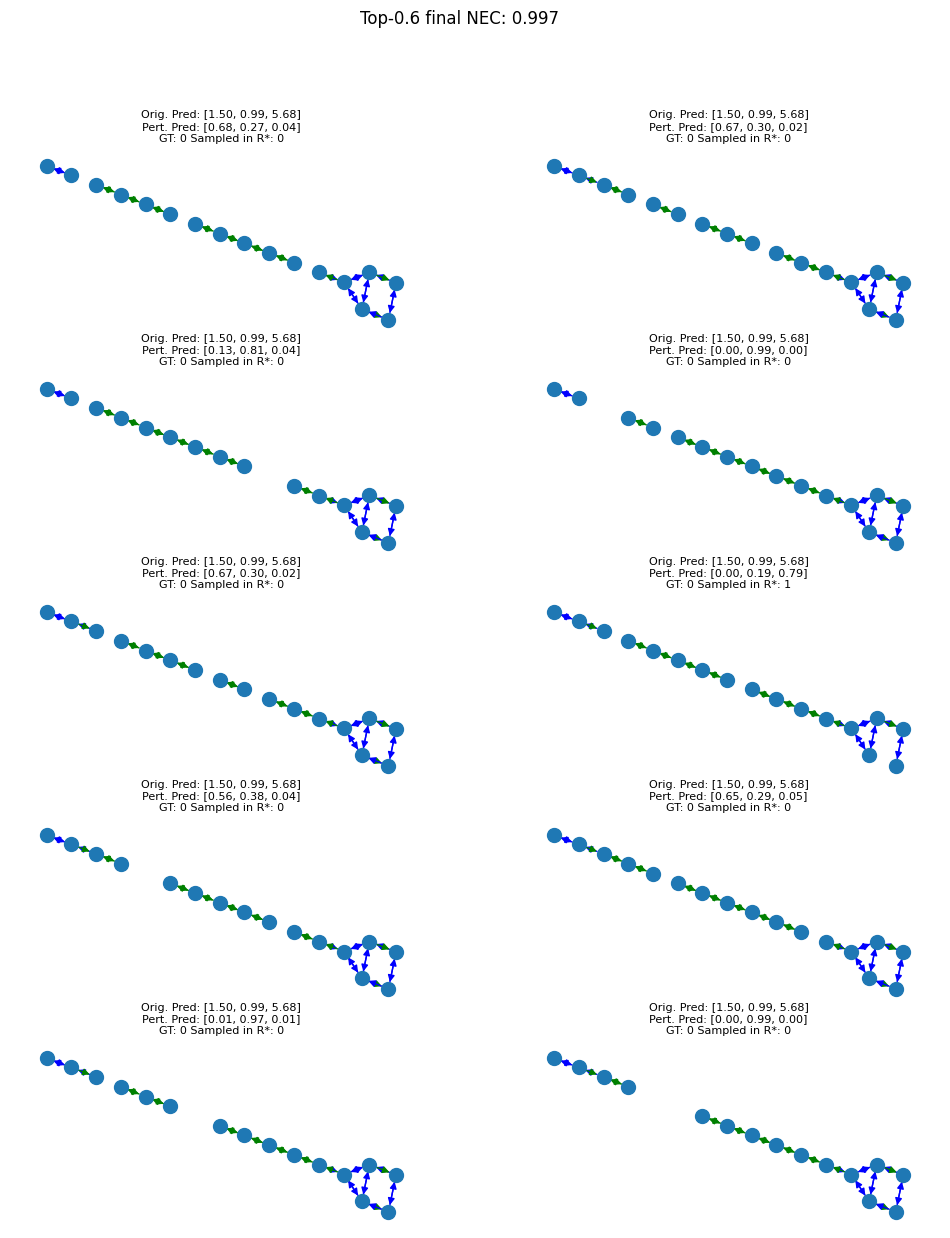

In [100]:
metric = "nec"
if metric == "nec++":
    alpha = max(config.nec_alpha_1 - 0.1 * (j // 3), 0.1)
else:
    alpha = config.nec_alpha_1

sampled_G = []
num_samples = 10
orig_predictions = predict_sample([G], tested_pipeline, ratio=ratio).repeat_interleave(num_samples, dim=0)
for j in range(num_samples):
    config.random_seed = 304 + j
    reset_random_seed(config)
    G_sampled, edges_in_gt = sample_edges(G, graphs[idx], alpha, causal_subgraphs_r[ratio][idx], ratio=1, num_to_remove=None)
    sampled_G.append((G_sampled, edges_in_gt))
    
predictions = predict_sample([s[0] for s in sampled_G], tested_pipeline, ratio=ratio)


# Compute NEC
div = torch.nn.KLDivLoss(reduction="none", log_target=True)(orig_predictions, predictions).sum(-1)
aggr = 1 - torch.exp(-scatter_mean(div, torch.zeros(predictions.shape[0], dtype=int, device=predictions.device), dim=0)) # on paper


predictions = torch.exp(predictions) # undo the log_softmax
orig_predictions = torch.exp(orig_predictions)
n_row = num_samples // 2
fig, axs = plt.subplots(n_row, 2, figsize=(12,14))
for j in range(num_samples):
    ax = axs[j // 2, j % 2]
    draw(config, sampled_G[j][0], name="", save=False, pos=pos, figsize=(3, 3), nodesize=100, with_labels=False, title=get_title_predition(orig_predictions, predictions, j, graphs[idx].y, sampled_G[j][1]), ax=ax);
plt.suptitle(f"Top-{ratio} final {metric.upper()}: {round(aggr.item(), 3)}")
plt.show()

### Manual investigation

Selected 56 relevant edges over 92


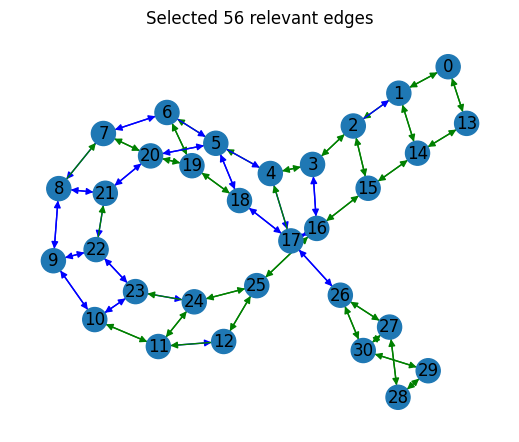

In [194]:
ratio = 0.6
idx = 100

G = graphs_nx[idx].copy()
xai_utils.mark_edges(G, causal_subgraphs_r[ratio][idx], spu_subgraphs_r[ratio][idx])
pos = xai_utils.draw(config, G, name="", save=False, figsize=(5, 4), nodesize=300, with_labels=True);

In [200]:
print(predict_sample([G], tested_pipeline).exp())

G_sampled, edges_in_gt = sample_edges(G, graphs[idx], "inv", alpha, causal_subgraphs_r[ratio][idx], ratio=ratio, edge_remove=[(7,8), (28,29), (12,25), (5,4), (5,6)])

print(predict_sample([G_sampled], tested_pipeline).exp())


tensor([[0.7160, 0.1929, 0.0912]])
tensor([[0.8879, 0.0821, 0.0300]])


## Stability of NEC for same ratio value

In [10]:
def sample_edges_rfid(G_ori, data, alpha, edge_index_to_remove=None):
    """Sampled edges based on Bernoulli"""
    # keep each spu/inv edge with probability alpha
    G = G_ori.copy()

    edge_remove = list()
    for (u,v) in edge_index_to_remove.T:
        if np.random.binomial(1, alpha, 1)[0] == 0:
            edge_remove.append((u.item(), v.item()))

    G.remove_edges_from(edge_remove)
    G.remove_edges_from([(v,u) for v,u in G.edges() if not G.has_edge(u,v)])
    G.remove_nodes_from(list(nx.isolates(G)))

    # count how many GT edges where removed
    edge_gt = {(u.item(),v.item()): bool(data.edge_gt[i]) for i, (u,v) in enumerate(data.edge_index.T)} 
    edges_in_gt = sum([edge_gt[e] for e in edge_remove])
    # print(f"Removing {edge_remove} edges")
    return G, edges_in_gt

# G_sampled_rfid, _ = sample_edges_rfid(G, graphs[idx], "inv", alpha, causal_subgraphs_r[ratio][idx])
# xai_utils.mark_edges(G_sampled_rfid, causal_subgraphs_r[ratio][idx], spu_subgraphs_r[ratio][idx])
# xai_utils.draw(config, G_sampled_rfid, name="", save=False, figsize=(4, 3), nodesize=100, with_labels=True);

In [16]:
metric = "nec"
if metric == "nec++":
    alpha = max(config.nec_alpha_1 - 0.1 * (j // 3), 0.1)
else:
    alpha = config.nec_alpha_1

ratios = [0.3, 0.4, 0.6, 0.7, 0.75, 0.8, 0.9, 1.]
num_samples = 10
num_seeds = 3
necs, change_of_pred, fid_label, fid_unsup, fid_div, rfid, rfid_div, accs = defaultdict(list), defaultdict(list), defaultdict(list), defaultdict(list), defaultdict(list), defaultdict(lambda: defaultdict(list)), defaultdict(lambda: defaultdict(list)), defaultdict(list)
nec_l1, necs_bernoulli = defaultdict(list), defaultdict(lambda: defaultdict(list))
necs_per_class = defaultdict(lambda: defaultdict(list))
preds, ori_preds = defaultdict(dict), defaultdict(dict)
idxs, _ = train_test_split(
    np.arange(len(graphs)),
    train_size=200,
    random_state=42,
    shuffle=True,
    stratify=[graphs[i].y.item() for i in range(len(graphs))]
)
for ratio in ratios:    
    for seed in range(num_seeds):        
        ori_graphs, sampled = [], []
        belonging, labels = [], torch.tensor([])
        labels_norep = torch.tensor([])
        for idx in idxs:
            G = graphs_nx[idx].copy()
            labels_norep = torch.cat((labels_norep, graphs[idx].y), dim=0)
            for j in range(num_samples):
                config.random_seed = 304 * seed + j
                reset_random_seed(config)
                # G_sampled, edges_in_gt = sample_edges(G, graphs[idx], alpha, causal_subgraphs_r[ratio][idx], ratio=1, num_to_remove=None, remove_undirected=False)
                G_sampled_rfid, _  = sample_edges_rfid(G, graphs[idx], 0.95, causal_subgraphs_r[ratio][idx])
                G_sampled_rfid2, _ = sample_edges_rfid(G, graphs[idx], 0.9, causal_subgraphs_r[ratio][idx])
                G_sampled_rfid3, _ = sample_edges_rfid(G, graphs[idx], 0.8, causal_subgraphs_r[ratio][idx])
                G_sampled_rfid4, _ = sample_edges_rfid(G, graphs[idx], 0.7, causal_subgraphs_r[ratio][idx])
                G_sampled_rfid5, _ = sample_edges_rfid(G, graphs[idx], 0.5, causal_subgraphs_r[ratio][idx])
                
                sampled.append((G_sampled_rfid,G_sampled_rfid2,G_sampled_rfid3,G_sampled_rfid4,G_sampled_rfid5))
                ori_graphs.append((G, np.nan))
                belonging.append(idx)
                labels = torch.cat((labels, graphs[idx].y), dim=0)
            
        pred_all = predict_sample([s[0] for s in ori_graphs] + [s[0] for s in sampled] + [s[1] for s in sampled]+ [s[2] for s in sampled]+ [s[3] for s in sampled]+ [s[4] for s in sampled], tested_pipeline, ratio=ratio)
        ori_pred = pred_all[:len(ori_graphs)]
        pred_rfid = pred_all[len(ori_graphs):len(ori_graphs) + len(sampled)]
        pred_rfid2 = pred_all[len(ori_graphs) + len(sampled):len(ori_graphs) + 2*len(sampled)]
        pred_rfid3 = pred_all[len(ori_graphs) + 2*len(sampled):len(ori_graphs) + 3*len(sampled)]
        pred_rfid4 = pred_all[len(ori_graphs) + 3*len(sampled):len(ori_graphs) + 4*len(sampled)]
        pred_rfid5 = pred_all[len(ori_graphs) + 4*len(sampled):len(ori_graphs) + 5*len(sampled)]
        
        # Compute NEC for all input samples
        belonging = normalize_belonging(belonging).to(pred_rfid.device)
        
        div = torch.nn.KLDivLoss(reduction="none", log_target=True)(ori_pred, pred_rfid).sum(-1)
        aggr_bernoulli = 1 - torch.exp(-scatter_mean(div, belonging, dim=0)) # formula on paper
        div = torch.nn.KLDivLoss(reduction="none", log_target=True)(ori_pred, pred_rfid2).sum(-1)
        aggr_bernoulli2 = 1 - torch.exp(-scatter_mean(div, belonging, dim=0)) # formula on paper
        div = torch.nn.KLDivLoss(reduction="none", log_target=True)(ori_pred, pred_rfid3).sum(-1)
        aggr_bernoulli3 = 1 - torch.exp(-scatter_mean(div, belonging, dim=0)) # formula on paper
        div = torch.nn.KLDivLoss(reduction="none", log_target=True)(ori_pred, pred_rfid4).sum(-1)
        aggr_bernoulli4 = 1 - torch.exp(-scatter_mean(div, belonging, dim=0)) # formula on paper
        div = torch.nn.KLDivLoss(reduction="none", log_target=True)(ori_pred, pred_rfid5).sum(-1)
        aggr_bernoulli5 = 1 - torch.exp(-scatter_mean(div, belonging, dim=0)) # formula on paper

        rfid[ratio][1].append(torch.abs(ori_pred.exp().gather(1, labels.long().unsqueeze(1)) - pred_rfid.exp().gather(1, labels.long().unsqueeze(1))).mean())
        rfid_div[ratio][1].append(torch.abs(ori_pred.exp() - pred_rfid.exp()).mean())
        necs_bernoulli[ratio][1].append(aggr_bernoulli.mean().item())

        rfid[ratio][2].append(torch.abs(ori_pred.exp().gather(1, labels.long().unsqueeze(1)) - pred_rfid2.exp().gather(1, labels.long().unsqueeze(1))).mean())
        rfid_div[ratio][2].append(torch.abs(ori_pred.exp() - pred_rfid2.exp()).mean())
        necs_bernoulli[ratio][2].append(aggr_bernoulli2.mean().item())

        rfid[ratio][3].append(torch.abs(ori_pred.exp().gather(1, labels.long().unsqueeze(1)) - pred_rfid3.exp().gather(1, labels.long().unsqueeze(1))).mean())
        rfid_div[ratio][3].append(torch.abs(ori_pred.exp() - pred_rfid3.exp()).mean())
        necs_bernoulli[ratio][3].append(aggr_bernoulli3.mean().item())

        rfid[ratio][4].append(torch.abs(ori_pred.exp().gather(1, labels.long().unsqueeze(1)) - pred_rfid4.exp().gather(1, labels.long().unsqueeze(1))).mean())
        rfid_div[ratio][4].append(torch.abs(ori_pred.exp() - pred_rfid4.exp()).mean())
        necs_bernoulli[ratio][4].append(aggr_bernoulli4.mean().item())

        rfid[ratio][5].append(torch.abs(ori_pred.exp().gather(1, labels.long().unsqueeze(1)) - pred_rfid5.exp().gather(1, labels.long().unsqueeze(1))).mean())
        rfid_div[ratio][5].append(torch.abs(ori_pred.exp() - pred_rfid5.exp()).mean())
        necs_bernoulli[ratio][5].append(aggr_bernoulli5.mean().item())

        accs[ratio].append(sum(labels == ori_pred.argmax(-1)) / pred_rfid.shape[0])



10130
[]
Data(edge_index=[2, 0], num_nodes=0)


AttributeError: 'GlobalStorage' object has no attribute 'ori_x'

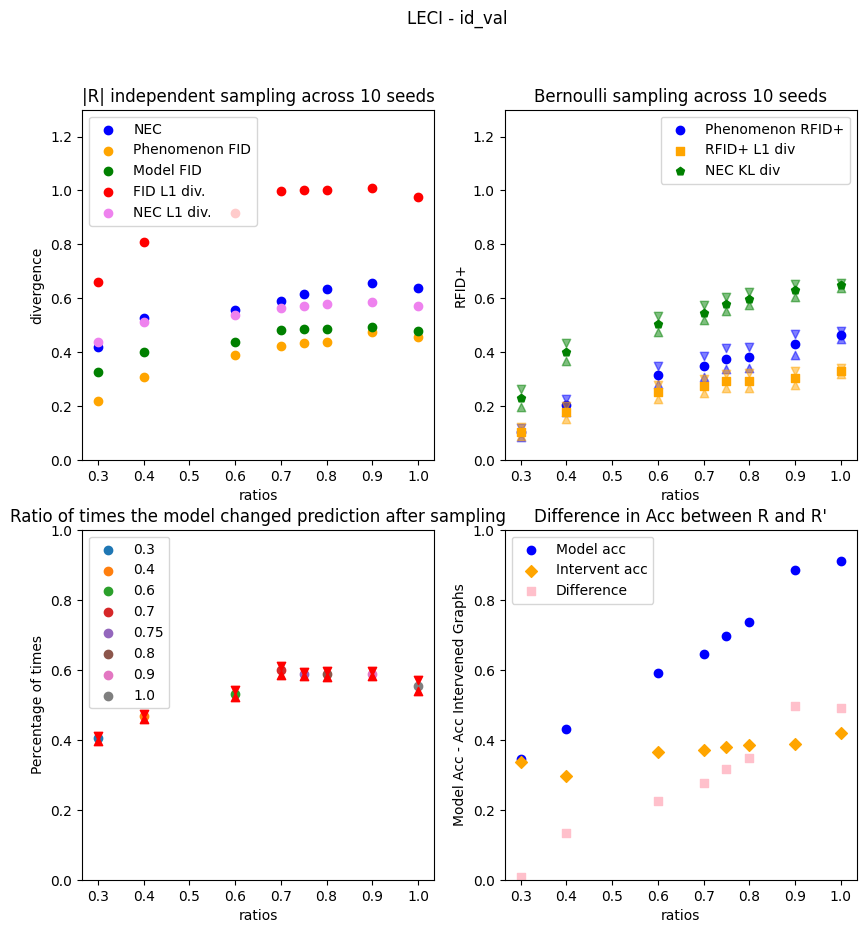

In [18]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

for r in ratios:
    axs[0,1].scatter(r, np.mean(rfid[r][1]), label="Phenomenon RFID+" if r == 0.3 else None, c="blue",)
    axs[0,1].scatter(r, np.mean(rfid[r][1]) + np.std(rfid[r][1]), c="blue", marker="v", alpha=0.5)
    axs[0,1].scatter(r, np.mean(rfid[r][1]) - np.std(rfid[r][1]), c="blue", marker="^", alpha=0.5)
    
    axs[0,1].scatter(r, np.mean(rfid_div[r][1]), c="orange", marker="s", label="RFID+ L1 div" if r == 0.3 else None)
    axs[0,1].scatter(r, np.mean(rfid_div[r][1]) + np.std(rfid_div[r][1]), c="orange", marker="v", alpha=0.5)
    axs[0,1].scatter(r, np.mean(rfid_div[r][1]) - np.std(rfid_div[r][1]), c="orange", marker="^", alpha=0.5)

    axs[0,1].scatter(r, np.mean(necs_bernoulli[r][1]), c="green", marker="p", label="NEC KL div" if r == 0.3 else None)
    axs[0,1].scatter(r, np.mean(necs_bernoulli[r][1]) + np.std(necs_bernoulli[r][1]), c="green", marker="v", alpha=0.5)
    axs[0,1].scatter(r, np.mean(necs_bernoulli[r][1]) - np.std(necs_bernoulli[r][1]), c="green", marker="^", alpha=0.5)
axs[0,0].legend()
axs[0,0].set_title(f"|R| independent sampling across 10 seeds")
axs[0,0].set_xlabel("ratios")
axs[0,0].set_ylabel("divergence")
axs[0,0].set_ylim((0., 1.3))

for r in ratios:
    axs[0,1].scatter(r, np.mean(rfid[r][2]), label="Phenomenon RFID+" if r == 0.3 else None, c="blue",)
    axs[0,1].scatter(r, np.mean(rfid[r][2]) + np.std(rfid[r]), c="blue", marker="v", alpha=0.5)
    axs[0,1].scatter(r, np.mean(rfid[r][2]) - np.std(rfid[r]), c="blue", marker="^", alpha=0.5)
    
    axs[0,1].scatter(r, np.mean(rfid_div[r][2]), c="orange", marker="s", label="RFID+ L1 div" if r == 0.3 else None)
    axs[0,1].scatter(r, np.mean(rfid_div[r][2]) + np.std(rfid_div[r][2]), c="orange", marker="v", alpha=0.5)
    axs[0,1].scatter(r, np.mean(rfid_div[r][2]) - np.std(rfid_div[r][2]), c="orange", marker="^", alpha=0.5)

    axs[0,1].scatter(r, np.mean(necs_bernoulli[r][2]), c="green", marker="p", label="NEC KL div" if r == 0.3 else None)
    axs[0,1].scatter(r, np.mean(necs_bernoulli[r][2]) + np.std(necs_bernoulli[r][2]), c="green", marker="v", alpha=0.5)
    axs[0,1].scatter(r, np.mean(necs_bernoulli[r][2]) - np.std(necs_bernoulli[r][2]), c="green", marker="^", alpha=0.5)
axs[0,1].legend()
axs[0,1].set_title("Bernoulli sampling across 10 seeds")
axs[0,1].set_xlabel("ratios")
axs[0,1].set_ylabel("RFID+")
axs[0,1].set_ylim((0., 1.3))

for r in ratios:
    axs[1,0].scatter(r, np.mean(change_of_pred[r]), label=r)
    axs[1,0].scatter(r, np.mean(change_of_pred[r]) + np.std(change_of_pred[r]), c="r", marker="v")
    axs[1,0].scatter(r, np.mean(change_of_pred[r]) - np.std(change_of_pred[r]), c="r", marker="^")
axs[1,0].legend()
axs[1,0].set_title("Ratio of times the model changed prediction after sampling")
axs[1,0].set_xlabel("ratios")
axs[1,0].set_ylabel("Percentage of times")
axs[1,0].set_ylim((0., 1.))

colors_r = {
    0.3: "blue",
    0.6: "orange",
    0.9: "green",
}
for r in ratios:
    axs[1,1].scatter(r, np.mean(accs[r]), c="blue", label="Model acc" if r == 0.3 else None)
    axs[1,1].scatter(r, np.mean([accuracy_score(labels, preds[r][s].argmax(-1)) for s in range(num_seeds)]), marker="D", c="orange", label="Intervent acc" if r == 0.3 else None)
    axs[1,1].scatter(r, np.mean(accs[r]) - np.mean([accuracy_score(labels, preds[r][s].argmax(-1)) for s in range(num_seeds)]), c="pink", marker="s", label="Difference" if r == 0.3 else None)
axs[1,1].legend()
axs[1,1].set_title("Difference in Acc between R and R'")
axs[1,1].set_xlabel("ratios")
axs[1,1].set_ylabel("Model Acc - Acc Intervened Graphs")
axs[1,1].set_ylim((0., 1.))
plt.suptitle(f"{MODEL} - {SPLIT}")
plt.show();

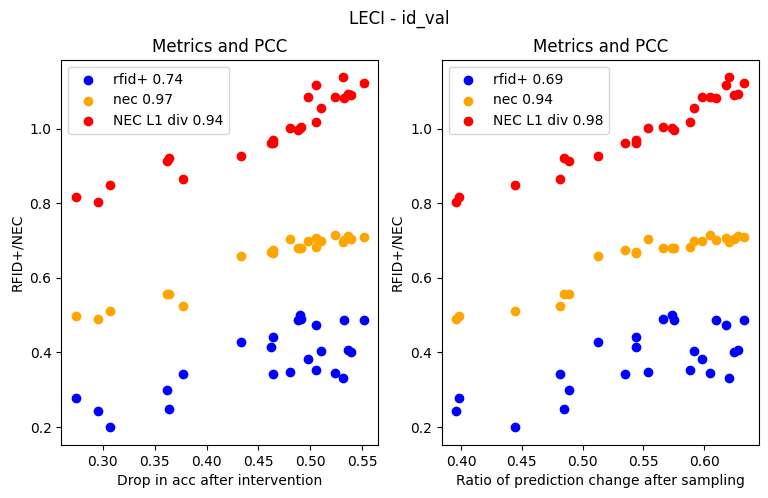

In [13]:
# Pearson correlation
acc_diff = [[accs[r][i] - accuracy_score(labels, preds[r][i].argmax(-1))] for r in ratios for i in range(num_seeds)]
ratio_change_pred = [[change_of_pred[r][i]] for r in ratios for i in range(num_seeds)]
nec_plot =[necs[r][i] for r in ratios for i in range(num_seeds)]
fid_plot = [rfid[r][i] for r in ratios for i in range(num_seeds)]
nec_l1_plot = [fid_div[r][i] for r in ratios for i in range(num_seeds)]

pcc_fid = r_regression(acc_diff, fid_plot)[0]
pcc_nec = r_regression(acc_diff, nec_plot)[0]
pcc_necl1 = r_regression(acc_diff, nec_l1_plot)[0]

pcc_fid2 = r_regression(ratio_change_pred, fid_plot)[0]
pcc_nec2 = r_regression(ratio_change_pred, nec_plot)[0]
pcc_necl12 = r_regression(ratio_change_pred, nec_l1_plot)[0]


fig, axs = plt.subplots(1, 2, figsize=(9, 5))

axs[0].scatter(acc_diff, fid_plot, c="blue", label=f"rfid+ {pcc_fid:.2f}")
axs[0].scatter(acc_diff, nec_plot, c="orange", label=metric + f" {pcc_nec:.2f}")
axs[0].scatter(acc_diff, nec_l1_plot, c="red", label=f"NEC L1 div {pcc_necl1:.2f}")

axs[0].legend()
axs[0].set_title(f"Metrics and PCC")
axs[0].set_xlabel("Drop in acc after intervention")
axs[0].set_ylabel(f"RFID+/{metric.upper()}")


axs[1].scatter(ratio_change_pred, fid_plot, c="blue", label=f"rfid+ {pcc_fid2:.2f}")
axs[1].scatter(ratio_change_pred, nec_plot, c="orange", label=metric + f" {pcc_nec2:.2f}")
axs[1].scatter(ratio_change_pred, nec_l1_plot, c="red", label=f"NEC L1 div {pcc_necl12:.2f}")

axs[1].legend()
axs[1].set_title(f"Metrics and PCC")
axs[1].set_xlabel("Ratio of prediction change after sampling")
axs[1].set_ylabel(f"RFID+/{metric.upper()}")

plt.suptitle(f"{MODEL} - {SPLIT}")
plt.show()



Class-wise plot

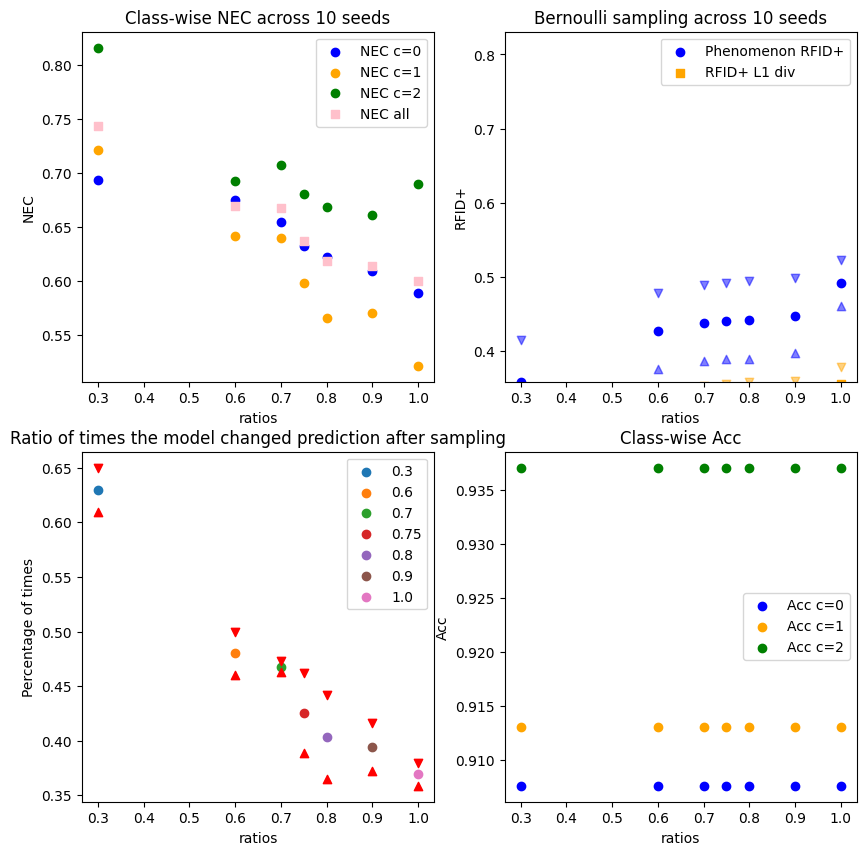

In [45]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

colors_c = {
    0: "blue",
    1: "orange",
    2: "green",
}
for r in ratios:
    sas = np.array([necs_per_class[r][c] for c in range(3)])
    for c in range(3):
        axs[0,0].scatter(r, np.mean(sas, axis=1)[c], label=f"{metric.upper()} c={c}" if r == 0.3 else None, c=colors_c[c])
    axs[0,0].scatter(r, np.mean(np.mean(sas, axis=1)), label=f"{metric.upper()} all" if r == 0.3 else None, c="pink", marker="s")
    # axs[0,0].scatter(r, np.mean(fid_label[r]), label=f"Phenomenon FID" if r == 0.3 else None, c="orange")
    # axs[0,0].scatter(r, np.mean(fid_unsup[r]), label=f"Model FID" if r == 0.3 else None, c="green")
    # axs[0,0].scatter(r, np.mean(fid_div[r]), label=f"FID L1 div." if r == 0.3 else None, c="red")
axs[0,0].legend()
axs[0,0].set_title(f"Class-wise {metric.upper()} across 10 seeds")
axs[0,0].set_xlabel("ratios")
axs[0,0].set_ylabel(metric.upper())

for r in ratios:
    axs[0,1].scatter(r, np.mean(rfid[r]), label="Phenomenon RFID+" if r == 0.3 else None, c="blue",)
    axs[0,1].scatter(r, np.mean(rfid[r]) + np.std(rfid[r]), c="blue", marker="v", alpha=0.5)
    axs[0,1].scatter(r, np.mean(rfid[r]) - np.std(rfid[r]), c="blue", marker="^", alpha=0.5)
    
    axs[0,1].scatter(r, np.mean(rfid_div[r]), c="orange", marker="s", label="RFID+ L1 div" if r == 0.3 else None)
    axs[0,1].scatter(r, np.mean(rfid_div[r]) + np.std(rfid_div[r]), c="orange", marker="v", alpha=0.5)
    axs[0,1].scatter(r, np.mean(rfid_div[r]) - np.std(rfid_div[r]), c="orange", marker="^", alpha=0.5)
axs[0,1].legend()
axs[0,1].set_title("Bernoulli sampling across 10 seeds")
axs[0,1].set_xlabel("ratios")
axs[0,1].set_ylabel("RFID+")
axs[0,1].set_ylim((min(np.mean(rfid[0.3]), axs[0,0].get_ylim()[0]), axs[0,0].get_ylim()[1]))

for r in ratios:
    axs[1,0].scatter(r, np.mean(change_of_pred[r]), label=r)
    axs[1,0].scatter(r, np.mean(change_of_pred[r]) + np.std(change_of_pred[r]), c="r", marker="v")
    axs[1,0].scatter(r, np.mean(change_of_pred[r]) - np.std(change_of_pred[r]), c="r", marker="^")
axs[1,0].legend()
axs[1,0].set_title("Ratio of times the model changed prediction after sampling")
axs[1,0].set_xlabel("ratios")
axs[1,0].set_ylabel("Percentage of times")

colors_r = {
    0.3: "blue",
    0.6: "orange",
    0.9: "green",
}
colors_c2 = {
    0: "black",
    1: "pink",
    2: "salmon",
}
for r in ratios:
    sas = [f1_score((labels == c).long(), (ori_preds[r][0].argmax(-1) == c).long()) for c in range(3)]
    # sas_int = [f1_score((labels == c).long(), (preds[r][0].argmax(-1) == c).long()) for c in range(3)]
    for c in range(3):
        axs[1,1].scatter(r, sas[c], c=colors_c[c], label=f"Acc c={c}" if r == 0.3 else None)
        # axs[1,1].scatter(r, sas_int[c], c=colors_c[c], label=f"Int. Acc c={c}" if r == 0.3 else None, alpha=0.5)
    # axs[1,1].scatter(r, np.mean(accs[r]) - accuracy_score(labels, preds[r][0].argmax(-1)), c="pink", marker="s", label="Difference" if r == 0.3 else None)
axs[1,1].legend()
axs[1,1].set_title("Class-wise Acc")
axs[1,1].set_xlabel("ratios")
axs[1,1].set_ylabel("Acc")
plt.show();

### Compare different sampling for NEC div

In [19]:
metric = "nec"
if metric == "nec++":
    alpha = max(config.nec_alpha_1 - 0.1 * (j // 3), 0.1)
else:
    alpha = config.nec_alpha_1

ratios = [0.3, 0.6, 0.7, 0.75, 0.8, 0.9, 1.]
num_samples = 10
num_seeds = 3
# necs, change_of_pred, fid_label, fid_unsup, fid_div, rfid, rfid_div, accs = defaultdict(list), defaultdict(list), defaultdict(list), defaultdict(list), defaultdict(list), defaultdict(list), defaultdict(list), defaultdict(list)
# nec_l1, necs_bernoulli = defaultdict(list), defaultdict(list)
# necs_per_class = defaultdict(lambda: defaultdict(list))
# preds, ori_preds = defaultdict(dict), defaultdict(dict)
metrics = defaultdict(lambda: defaultdict(list))
accs = defaultdict(list)
idxs, _ = train_test_split(
    np.arange(len(graphs)),
    train_size=200,
    random_state=42,
    shuffle=True,
    stratify=[graphs[i].y.item() for i in range(len(graphs))]
)
for ratio in ratios:    
    for seed in range(num_seeds):        
        ori_graphs, sampled = [], []
        belonging, labels = [], torch.tensor([])
        labels_norep = torch.tensor([])
        for idx in idxs:
            G = graphs_nx[idx].copy()
            labels_norep = torch.cat((labels_norep, graphs[idx].y), dim=0)
            for j in range(num_samples):
                config.random_seed = 304 * seed + j
                reset_random_seed(config)
                
                G_sampled_alphaG, _           = sample_edges(G, graphs[idx], alpha, causal_subgraphs_r[ratio][idx], ratio=1, num_to_remove=None, remove_undirected=False)
                G_sampled_loweralphaG, _      = sample_edges(G, graphs[idx], alpha/2, causal_subgraphs_r[ratio][idx], ratio=1, num_to_remove=None, remove_undirected=False)
                G_sampled_alphaGundirected, _ = sample_edges(G, graphs[idx], alpha/2, causal_subgraphs_r[ratio][idx], ratio=1, num_to_remove=None, remove_undirected=True)
                G_sampled_always1, _          = sample_edges(G, graphs[idx], alpha, causal_subgraphs_r[ratio][idx], ratio=1, num_to_remove=1, remove_undirected=False)
                G_sampled_necpp, _            = sample_edges(G, graphs[idx], max(config.nec_alpha_1-0.1*(j // 3), 0.1), causal_subgraphs_r[ratio][idx], ratio=1, num_to_remove=None, remove_undirected=False)
                G_sampled_necpp2, _           = sample_edges(G, graphs[idx], max((config.nec_alpha_1 + 0.05)-0.05*(j // 2), 0.1), causal_subgraphs_r[ratio][idx], ratio=1, num_to_remove=None, remove_undirected=False)
                
                sampled.append((G_sampled_alphaG, G_sampled_loweralphaG, G_sampled_alphaGundirected, G_sampled_always1, G_sampled_necpp, G_sampled_necpp2))
                ori_graphs.append((G, np.nan))
                belonging.append(idx)
                labels = torch.cat((labels, graphs[idx].y), dim=0)
            
        pred_all = predict_sample(
            [s[0] for s in ori_graphs] + [s[0] for s in sampled] + [s[1] for s in sampled] + [s[2] for s in sampled] + [s[3] for s in sampled] + [s[4] for s in sampled] + [s[5] for s in sampled],
            tested_pipeline,
            ratio=ratio
        )
        ori_pred = pred_all[:len(ori_graphs)]
        
        pred_alphaG = pred_all[len(ori_graphs):len(ori_graphs) + len(sampled)]
        pred_loweralphaG = pred_all[len(ori_graphs) + len(sampled): len(ori_graphs) + 2*len(sampled)]
        pred_alphaGundirected = pred_all[len(ori_graphs) + 2*len(sampled): len(ori_graphs) + 3*len(sampled)]
        pred_always1 = pred_all[len(ori_graphs) + 3*len(sampled): len(ori_graphs) + 4*len(sampled)]
        pred_necpp = pred_all[len(ori_graphs) + 4*len(sampled): len(ori_graphs) + 5*len(sampled)]
        pred_necpp2 = pred_all[len(ori_graphs) + 5*len(sampled): len(ori_graphs) + 6*len(sampled)]
        
        belonging = normalize_belonging(belonging).to(pred_alphaG.device)

        def nec_kl(ori_pred, pred, belonging, labels):
            return 1 - torch.exp(-scatter_mean(torch.nn.KLDivLoss(reduction="none", log_target=True)(ori_pred, pred).sum(-1), belonging, dim=0))
        def nec_l1(ori_pred, pred, belonging, labels):
            return 1 - torch.exp(-scatter_mean(torch.abs(ori_pred.exp() - pred.exp()).sum(-1), belonging, dim=0))
        def fid_l1_div(ori_pred, pred, belonging, labels):
            return torch.abs(ori_pred.exp() - pred.exp()).sum(-1).mean()
        def fid_model(ori_pred, pred, belonging, labels):
            return torch.abs(ori_pred.exp().gather(1, ori_pred.argmax(-1).unsqueeze(1)) - pred.exp().gather(1, ori_pred.argmax(-1).unsqueeze(1))).mean()
        def fid_phenom(ori_pred, pred, belonging, labels):
            return torch.abs(ori_pred.exp().gather(1, labels.long().unsqueeze(1)) - pred.exp().gather(1, labels.long().unsqueeze(1))).mean()

        divergences = {
            "alphaG": {},
            "loweralphaG": {},
            "alphaGundirected": {},
            "always1": {},
            "nec++": {},
            "nec++2": {},
        }
        for metric_name, div_f in zip(["NEC KL", "NEC L1", "FID L1 div", "Model FID", "Phen. FID"], [nec_kl, nec_l1, fid_l1_div, fid_model, fid_phenom]):
            divergences["alphaG"][metric_name]           = div_f(ori_pred, pred_alphaG, belonging, labels).mean().item()
            divergences["loweralphaG"][metric_name]      = div_f(ori_pred, pred_loweralphaG, belonging, labels).mean().item()
            divergences["alphaGundirected"][metric_name] = div_f(ori_pred, pred_alphaGundirected, belonging, labels).mean().item()
            divergences["always1"][metric_name]          = div_f(ori_pred, pred_always1, belonging, labels).mean().item()
            divergences["nec++"][metric_name]            = div_f(ori_pred, pred_necpp, belonging, labels).mean().item()
            divergences["nec++2"][metric_name]           = div_f(ori_pred, pred_necpp2, belonging, labels).mean().item()

        metrics[ratio][seed] = divergences
        accs[ratio].append(sum(labels == ori_pred.argmax(-1)) / ori_pred.shape[0])

        # necs[ratio].append(aggr.mean().item())
        # change_of_pred[ratio].append(sum(ori_pred.argmax(-1) != pred.argmax(-1)) / pred.shape[0])
        # fid_label[ratio].append(torch.abs(ori_pred.exp().gather(1, labels.long().unsqueeze(1)) - pred.exp().gather(1, labels.long().unsqueeze(1))).mean()) # NEC with d=L1 wrt Phenomenon
        # fid_unsup[ratio].append(torch.abs(ori_pred.exp().gather(1, ori_pred.argmax(-1).unsqueeze(1)) - pred.exp().gather(1, ori_pred.argmax(-1).unsqueeze(1))).mean()) # NEC with d=L1 wrt Model
        # fid_div[ratio].append(torch.abs(ori_pred.exp() - pred.exp()).sum(-1).mean()) # NEC with d=L1 wrt the entire distribution
        # nec_l1[ratio].append(aggr_l1.mean().item())

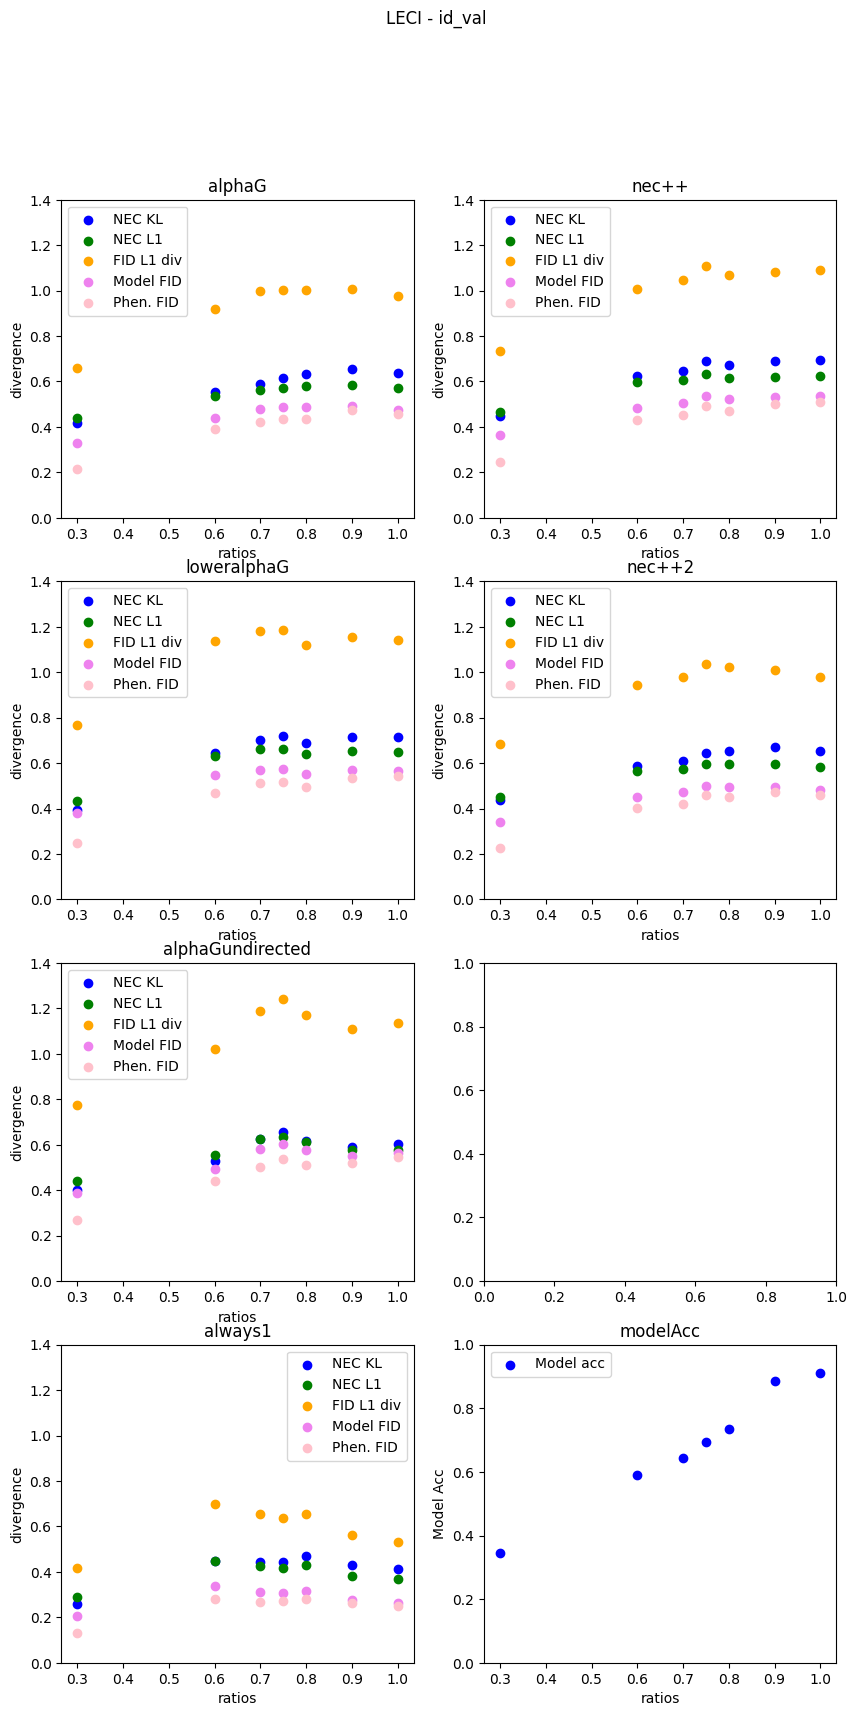

In [20]:
num_rows = 4
fig, axs = plt.subplots(num_rows, 2, figsize=(10, 19))

for i, method in enumerate(["alphaG", "loweralphaG", "alphaGundirected", "always1", "nec++", "nec++2"]):
    for r in ratios:
        axs[i%num_rows,i//num_rows].scatter(r, np.mean([metrics[r][s][method]["NEC KL"] for s in range(num_seeds)]), label=f"NEC KL" if r == 0.3 else None, c="blue")
        axs[i%num_rows,i//num_rows].scatter(r, np.mean([metrics[r][s][method]["NEC L1"] for s in range(num_seeds)]), label=f"NEC L1" if r == 0.3 else None, c="green")
        axs[i%num_rows,i//num_rows].scatter(r, np.mean([metrics[r][s][method]["FID L1 div"] for s in range(num_seeds)]), label=f"FID L1 div" if r == 0.3 else None, c="orange")
        axs[i%num_rows,i//num_rows].scatter(r, np.mean([metrics[r][s][method]["Model FID"] for s in range(num_seeds)]), label=f"Model FID" if r == 0.3 else None, c="violet")
        axs[i%num_rows,i//num_rows].scatter(r, np.mean([metrics[r][s][method]["Phen. FID"] for s in range(num_seeds)]), label=f"Phen. FID" if r == 0.3 else None, c="pink")
    axs[i%num_rows,i//num_rows].legend()
    axs[i%num_rows,i//num_rows].set_title(f"{method}")
    axs[i%num_rows,i//num_rows].set_xlabel("ratios")
    axs[i%num_rows,i//num_rows].set_ylabel("divergence")
    axs[i%num_rows,i//num_rows].set_ylim((0., 1.4))

for r in ratios:
    axs[-1,1].scatter(r, np.mean(accs[r]), c="blue", label="Model acc" if r == 0.3 else None)
axs[-1,1].legend()
axs[-1,1].set_title("modelAcc")
axs[-1,1].set_xlabel("ratios")
axs[-1,1].set_ylabel("Model Acc")
axs[-1,1].set_ylim((0., 1.))

plt.suptitle(f"{MODEL} - {SPLIT}")
plt.show();

## Probability plot for sampling strategies

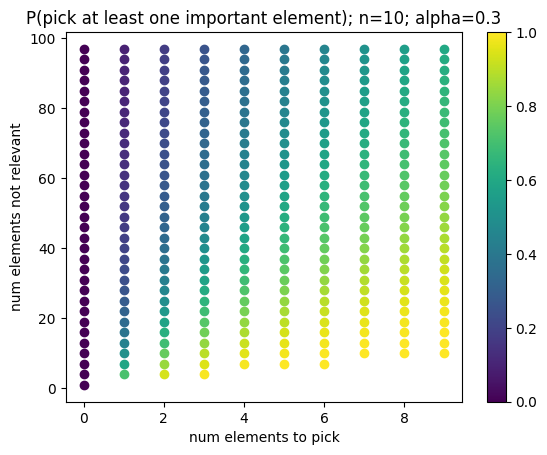

In [96]:
import math
import matplotlib as mpl

bias = False
alpha = 0.3
n = 10

def prob_at_least_one_black(b, k):
    # from hypergeometric distribution
    return 1 - math.factorial(b) / math.factorial(b - k) * math.factorial(b + n - k) / math.factorial(b + n)

for b in np.arange(1, 100, step=3):
    if not bias:
        for k in range(10):
            if b > k:
                p = prob_at_least_one_black(b, k)
                plt.scatter(k, b, c=p, vmin=0., vmax=1.)
    else:
        k = int(alpha * b)
        p = prob_at_least_one_black(b, k)
        plt.scatter(k, b, c=p, vmin=0., vmax=1.)
    
plt.xlabel("num elements to pick")
plt.ylabel("num elements not relevant")
plt.title(f"P(pick at least one important element); n={n}; alpha={alpha}")
plt.colorbar();

Same as before, but with a different parametrization to debug CIGA

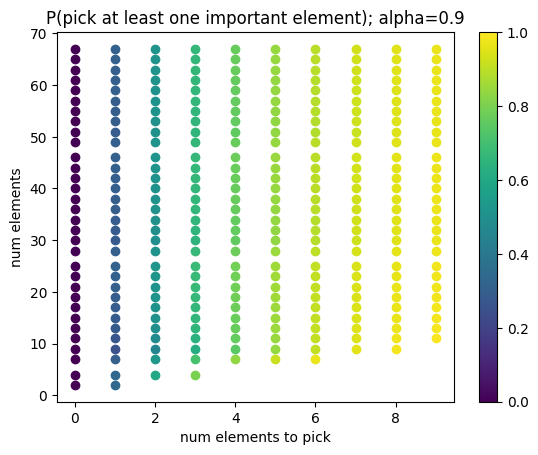

In [95]:
import math
import matplotlib as mpl

bias = False

def prob_at_least_one_black(b, k):
    # from hypergeometric distribution
    return 1 - math.factorial(b) / math.factorial(b - k) * math.factorial(b + n - k) / math.factorial(b + n)

for total in np.arange(1, 100, step=3):
    b = int(0.7 * total)
    n = int(0.3 * total)
    if not bias:
        for k in range(10):
            if b > k:
                p = prob_at_least_one_black(b, k)
                plt.scatter(k, b, c=p, vmin=0., vmax=1.)
    else:
        k = int(alpha * b)
        p = prob_at_least_one_black(b, k)
        plt.scatter(k, b, c=p, vmin=0., vmax=1.)
    
plt.xlabel("num elements to pick")
plt.ylabel("num elements")
plt.title(f"P(pick at least one important element); alpha={alpha}")
plt.colorbar();